Welcome to this Jupyter Notebook tutorial parameters relating to computational resources. In this tutorial, we will cover the following parameters:

`population_size`

`initial_population_size`

`population_scaling`

`generations_until_end_population`

`budget_range`

`generations_until_end_budget`

`budget_scaling`

`stepwise_steps`

Population size is the number of individuals evaluated each generation. Budget refers to the proportion of data to sample. By manipulating these parameters, we can control how quickly the budget increases and how population size changes over time. Most often, this will be used to start the algorithm by evaluating a large number of pipelines on small subsets of the data to quickly narrow now best models, before later getting a better estimate with larger samples on fewer datasets. This can reduce overall computational cost by not spending as much time evaluating poor performing pipelines.

`population_size` determines the number of individuals to evalaute each generation. Sometimes we may want to evaluate more or fewer individuals in the earlier generations. The `initial_population_size` parameter specifies the starting size of the population. The population size will gradually move from `initial_population_size` to `population_size` over the course of `generations_until_end_population` generations. `population_scaling` dictates how fast that scaling takes place. The interpolation over `generations_until_end_population` is done stepwise with the number of steps specified by `stepwise_steps`.

The same process goes for the budget scaling. 



The following cell illustrates how the population size and budget change over time with the given settings.

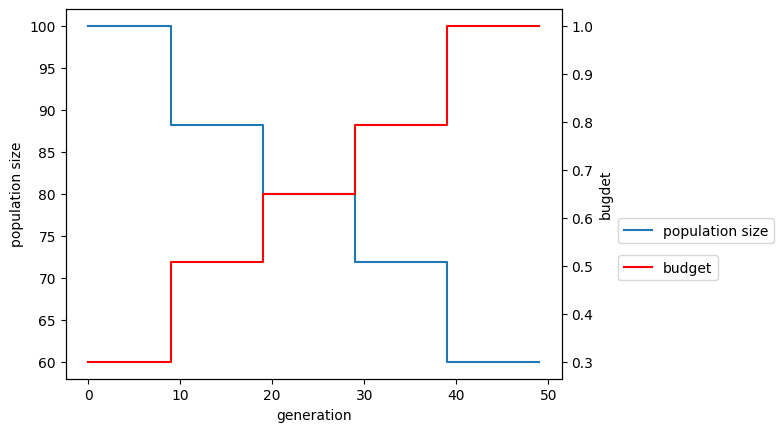

In [1]:
import matplotlib.pyplot as plt
import tpot2

population_size=60
initial_population_size=100
population_scaling = .5
generations_until_end_population = 50

budget_range = [.3,1]
generations_until_end_budget=50
budget_scaling = .5
stepwise_steps = 5

#Population and budget use stepwise
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

interpolated_values_population = tpot2.utils.beta_interpolation(start=initial_population_size, end=population_size, n=generations_until_end_population, n_steps=stepwise_steps, scale=population_scaling)
interpolated_values_budget = tpot2.utils.beta_interpolation(start=budget_range[0], end=budget_range[1], n=generations_until_end_budget, n_steps=stepwise_steps, scale=budget_scaling)
ax1.step(list(range(len(interpolated_values_population))), interpolated_values_population, label=f"population size")
ax2.step(list(range(len(interpolated_values_budget))), interpolated_values_budget, label=f"budget", color='r')
ax1.set_xlabel("generation")
ax1.set_ylabel("population size")
ax2.set_ylabel("bugdet")

ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.4))
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.3))
plt.show()


In [2]:
# A Graph pipeline starting with at least one selector as a leaf, potentially followed by a series
# of stacking classifiers or transformers, and ending with a classifier. The graph will have at most 15 nodes and a max depth of 6.

import tpot2
import sklearn
import sklearn.datasets
import numpy as np
import time
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

X, y = sklearn.datasets.load_iris(return_X_y=True)

est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=2,
                            max_eval_time_seconds=30,

                            population_size=population_size,
                            initial_population_size=initial_population_size,
                            population_scaling = population_scaling,
                            generations_until_end_population = generations_until_end_population,
                            
                            budget_range = budget_range,
                            generations_until_end_budget=generations_until_end_budget,
                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

2023-06-14 11:49:45,920 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-q6nay1zr', purging
2023-06-14 11:49:45,921 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wni1q2fv', purging
2023-06-14 11:49:45,921 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kunoeg91', purging
2023-06-14 11:49:45,921 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-40sr99dr', purging
2023-06-14 11:49:45,922 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_b9njy2q', purging
2023-06-14 11:49:45,922 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-qft6b6eq', purging
2023-06-14 11:49:45,922 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cgnqe8s_', purging

total time: 17.05474090576172


Tutorial on early termination of evaluating CV scores.

We can further reduce computational load by terminating the evaluation of individual pipelines early if the first few CV scores are not promising. Note that this is different than early stopping of the full algorithm. In this section we will cover:

`threshold_evaluation_early_stop`

`threshold_evaluation_scaling`

`min_history_threshold`

`selection_evaluation_early_stop`

`selection_evaluation_scaling`

Threshold early stopping uses previous scores to identify and terminate the cross validation evaluation of poorly performing pipelines. We calculate the percentile scores from the previously evaluated pipelines. A pipeline must reach the given percentile each fold for the next to be evaluated, otherwise the pipeline is discarded.

The `threshold_evaluation_early_stop` parameter is a list that specifies the starting and ending percentiles to use as a threshold for the evaluation early stopping. W The `threshold_evaluation_scaling` parameter is a float that controls the rate at which the threshold moves from the start to end percentile. The `min_history_threshold` parameter specifies the minimum number of previous scores needed before using threshold early stopping. This ensures that the algorithm has enough historical data to make an informed decision about when to stop evaluating pipelines.

Selection early stopping uses a selection algorithm after each fold to select which algorithms will be evaluated for the next fold. For example, after evaluating 100 individuals on fold 1, we may want to only evaluate the best 50 for the remaining folds.

The `selection_evaluation_early_stop` parameter is a list that specifies the lower and upper percentage of the population size to select each round of CV. This is used to determine which individuals to evaluate in the next generation. The `selection_evaluation_scaling` parameter is a float that controls the rate at which the selection threshold moves from the start to end percentile.

By manipulating these parameters, we can control how the algorithm selects individuals to evaluate in the next generation and when to stop evaluating pipelines that are not performing well.

In practice, the values of these parameters will depend on the specific problem and the available computational resources. 

In the following sections, we will show you how to set and manipulate these parameters using Python code in a Jupyter Notebook. We will also provide examples of how these parameters can affect the performance of the algorithm.

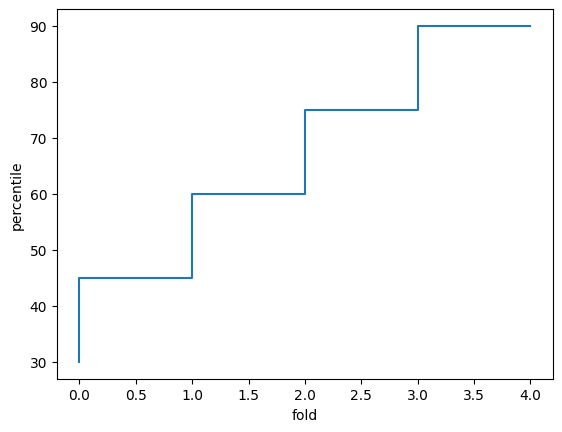

In [3]:
import matplotlib.pyplot as plt
import tpot2

threshold_evaluation_early_stop = [30, 90]
threshold_evaluation_scaling = .5
cv = 5

#Population and budget use stepwise
fig, ax1 = plt.subplots()

interpolated_values = tpot2.utils.beta_interpolation(start=threshold_evaluation_early_stop[0], end=threshold_evaluation_early_stop[-1], n=cv, n_steps=cv, scale=threshold_evaluation_scaling)
ax1.step(list(range(len(interpolated_values))), interpolated_values, label=f"threshold")
ax1.set_xlabel("fold")
ax1.set_ylabel("percentile")
#ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.4))
plt.show()


In [4]:
est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=cv,
                            
                            # budget_range = [.3,1],
                            # generations_until_end_budget=4,

                            threshold_evaluation_early_stop = threshold_evaluation_early_stop,
                            threshold_evaluation_scaling = threshold_evaluation_scaling,
                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

total time: 23.97980833053589


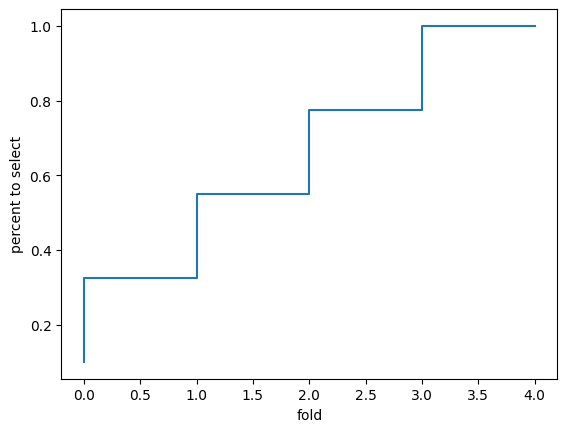

In [5]:
import matplotlib.pyplot as plt
import tpot2

selection_evaluation_early_stop = [.1, 1]
selection_evaluation_scaling = .5
cv = 5

#Population and budget use stepwise
fig, ax1 = plt.subplots()

interpolated_values = tpot2.utils.beta_interpolation(start=selection_evaluation_early_stop[0], end=selection_evaluation_early_stop[-1], n=cv, n_steps=cv, scale=selection_evaluation_scaling)
ax1.step(list(range(len(interpolated_values))), interpolated_values, label=f"threshold")
ax1.set_xlabel("fold")
ax1.set_ylabel("percent to select")
#ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.4))
plt.show()


In [6]:
est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=cv,

                            selection_evaluation_early_stop  = selection_evaluation_early_stop,
                            selection_evaluation_scaling = selection_evaluation_scaling,

                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

total time: 23.03678798675537


All of the above methods can be used independently or simultaneously as done below:

In [7]:
import math
np.array([1.2,3.4,1])

array([1.2, 3.4, 1. ])

In [8]:
est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=cv,

                            population_size=population_size,
                            initial_population_size=initial_population_size,
                            population_scaling = population_scaling,
                            generations_until_end_population = generations_until_end_population,
                            
                            budget_range = budget_range,
                            generations_until_end_budget=generations_until_end_budget,
                            
                            threshold_evaluation_early_stop = threshold_evaluation_early_stop,
                            threshold_evaluation_scaling = threshold_evaluation_scaling,

                            selection_evaluation_early_stop  = selection_evaluation_early_stop,
                            selection_evaluation_scaling = selection_evaluation_scaling,

                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


total time: 36.7981653213501
